In [1]:
from skimage.feature import register_translation
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import scipy
import tensorflow as tf
from sopt.examples.utils import PtychographySimulation
from sopt.examples.tensorflow.far_field_ptychography.tfPtycho import AdamPhaseRetriever
import sopt.benchmarks.ops.tensorflow.flops_registry_custom
from tensorflow.python.framework import graph_util
from sopt.benchmarks.ops.tensorflow.graph_utils_custom import get_flops_for_sub_graph, get_flops_for_node_list

In [2]:
%load_ext autoreload
%autoreload 2

/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


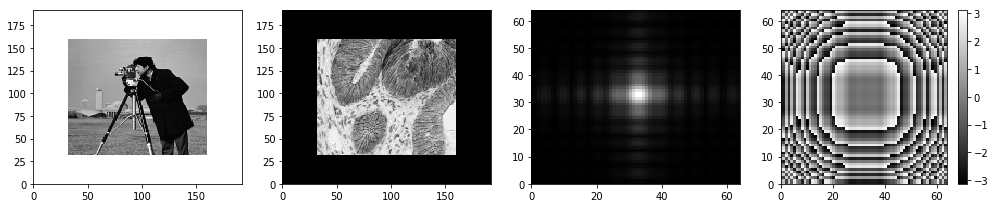

In [3]:
obj_padding_npix = 32
ptsim = PtychographySimulation(obj_npix=128, obj_padding_npix=obj_padding_npix,
                               positions_step_npix=6, probe_n_photons=1e3)

fig, axs = plt.subplots(1, 4, figsize=[14,3])
cax0 = axs[0].pcolormesh(np.abs(ptsim._obj_padded), cmap='gray')
cax1 = axs[1].pcolormesh(np.angle(ptsim._obj_padded), cmap='gray')
cax2 = axs[2].pcolormesh(np.abs(ptsim._probe_true), cmap='gray')
cax3 = axs[3].pcolormesh(np.angle(ptsim._probe_true), cmap='gray')
plt.colorbar(cax3)
plt.tight_layout()
plt.show()

## Adam - reconstructing the object only

### Gridsearch for the best hyperparameter choice

In [4]:
def runAdam(learning_rate_obj):
    pr_adam = AdamPhaseRetriever(ptsim=ptsim, probe_recons=False, validation_ndiffs=50)
    pr_adam.setOptimizingParams(learning_rate_obj=learning_rate_obj)
    pr_adam.initSession()
    pr_adam.run(debug_output_epoch_frequency=100)
    return pr_adam.data.copy()

In [5]:
grid_obj = np.logspace(-2, 0, 3)
grid_data = []
for lo in grid_obj:
    print(lo)
    run_data = runAdam(lo)
    grid_data.append(run_data.copy())
    print('Final', run_data.tail(n=1))

0.01
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


100 29629.84 0.4774853      150 3611.197 3613.929

Final              loss  epoch  obj_error  probe_error  validation_loss  patience
165  28999.458984  165.0     0.4166          NaN      3545.043457     165.0
0.1



Final             loss  epoch  obj_error  probe_error  validation_loss  patience
72  29190.058594   72.0   0.357336          NaN      3234.891846      72.0
1.0


100 28848.65 0.3565701    100.5 3583.986 3584.198

Final              loss  epoch  obj_error  probe_error  validation_loss  patience
101  28848.345703  101.0   0.356613          NaN      3583.924805     100.5


In [12]:
pr_adam = AdamPhaseRetriever(ptsim=ptsim, probe_recons=False, validation_ndiffs=50)
pr_adam.setOptimizingParams(learning_rate_obj=0.1)
pr_adam.initSession()

In [13]:
pr_adam.run(debug_output_epoch_frequency=100)
print(pr_adam.data.tail(n=2))


            loss  epoch  obj_error  probe_error  validation_loss  patience
68  28772.593750   68.0   0.360826          NaN      3666.584229      69.0
69  28771.234375   69.0   0.360447          NaN      3666.387207      69.0


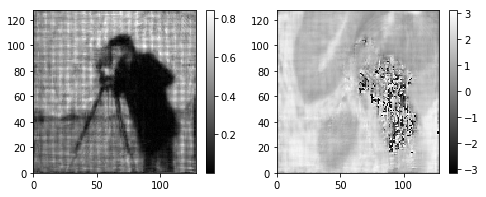

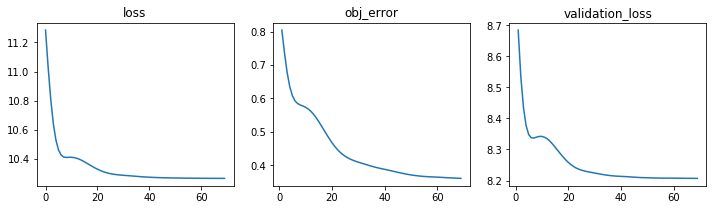

In [14]:
pr_adam.genPlotsRecons()
pr_adam.genPlotMetrics()

In [15]:
with pr_adam.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_adam = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_adam = flops_adam.total_float_ops
    print(flops_adam)

graph_def = pr_adam.graph.as_graph_def()
# To calculate the flops required for one adam step,
# I am removing the nodes required for the validation step.
nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr_adam.graph, nodes_validation)
print(flops_validation)

total_flops = (flops_adam - flops_validation) * pr_adam.data.index[-1]
print(f'total flops {total_flops:4.3g}')

Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
548458897
22777709
total flops 3.63e+10


## Adam minibatch 100

In [18]:
def runAdamBatched(learning_rate_obj):
    pr_adam = AdamPhaseRetriever(ptsim=ptsim, probe_recons=False, batch_size=100, validation_ndiffs=50)
    pr_adam.setOptimizingParams(learning_rate_obj=learning_rate_obj)
    pr_adam.initSession()
    pr_adam.run(debug_output_epoch_frequency=100)
    return pr_adam.data.copy()

In [19]:
grid_obj = np.logspace(-2, 0, 3)
grid_data = []
for lo in grid_obj:
    print(lo)
    run_data = runAdamBatched(lo)
    grid_data.append(run_data.copy())
    print('Final', run_data.tail(n=1))

0.01



Final             loss  epoch  obj_error  probe_error  validation_loss  patience
308  6564.219727   77.0   0.393639          NaN      3031.678223      76.5
0.1



Final             loss  epoch  obj_error  probe_error  validation_loss  patience
200  6655.146484   50.0   0.362338          NaN      3133.055664      50.0
1.0



Final              loss  epoch  obj_error  probe_error  validation_loss  patience
200  14607.345703   50.0   0.768158          NaN      6572.224121      50.0


In [29]:
pr_adam = AdamPhaseRetriever(ptsim=ptsim, probe_recons=False, batch_size=100, validation_ndiffs=50)
pr_adam.setOptimizingParams(learning_rate_obj=0.01)
pr_adam.initSession()
pr_adam.run(debug_output_epoch_frequency=100)
print(pr_adam.data.tail(n=2))

            loss  epoch  obj_error  probe_error  validation_loss  patience
299  6525.136719   74.0        NaN          NaN              NaN       NaN
300  6999.927734   75.0    0.39589          NaN      3416.539551      75.0


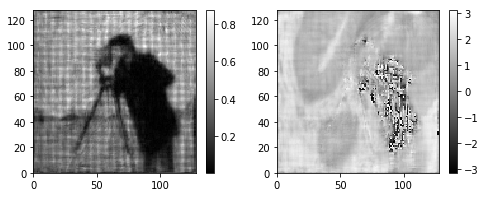

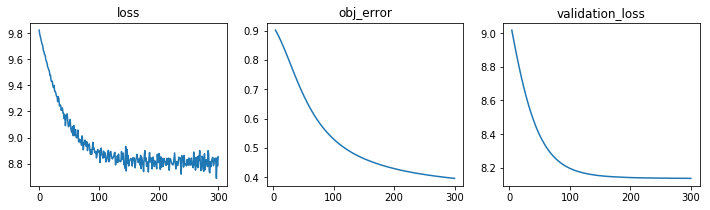

In [30]:
pr_adam.genPlotsRecons()
pr_adam.genPlotMetrics()

In [31]:
with pr_adam.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_adam = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_adam = flops_adam.total_float_ops
    print(flops_adam)

graph_def = pr_adam.graph.as_graph_def()
# To calculate the flops required for one adam step,
# I am removing the nodes required for the validation step.
nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr_adam.graph, nodes_validation)
print(flops_validation)

total_flops = (flops_adam - flops_validation) * pr_adam.data.index[-1]
print(f'total flops {total_flops:4.3g}')


135363877
22777709
total flops 3.38e+10


## Trying out the L4 optimizer

In [32]:
from L4 import L4Adam

In [33]:
pr_adam = AdamPhaseRetriever(ptsim=ptsim, probe_recons=False, validation_ndiffs=50)

In [34]:
with pr_adam.graph.as_default():
    pr_adam._batch_predicted_data = pr_adam._training_predictions_fn(pr_adam._tf_obj, pr_adam._tf_probe)
            
    pr_adam._optparams.training_loss_tensor = pr_adam._training_loss_fn(pr_adam._batch_predicted_data)
            
    pr_adam._optparams.obj_optimizer = L4Adam(0.15)
    pr_adam._optparams.obj_minimize_op = pr_adam._optparams.obj_optimizer.minimize(pr_adam._optparams.training_loss_tensor,
                                                        var_list=[pr_adam._tf_obj])
            
    if pr_adam._probe_recons:
        pr_adam._optparams.probe_optimizer = L4Adam(0.15)
        pr_adam._optparams.probe_minimize_op = pr_adam._optparams.probe_optimizer.minimize(pr_adam._optparams.training_loss_tensor, 
                                                                var_list=[pr_adam._tf_probe])
pr_adam._optimizers_defined = True

In [35]:
pr_adam.initSession()

In [36]:
pr_adam.run(debug_output_epoch_frequency=100, improvement_threshold=5e-4, patience=50)
print(pr_adam.data.tail(n=2))

100 33141.46 0.495555    112.5 4144.385 3721.183
             loss  epoch  obj_error  probe_error  validation_loss  patience
112  33822.023438  112.0   0.441909          NaN      3867.262207     112.5
113  30825.177734  113.0   0.523210          NaN      4400.105469     112.5


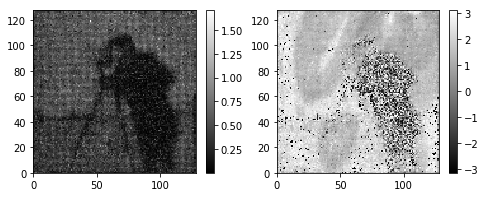

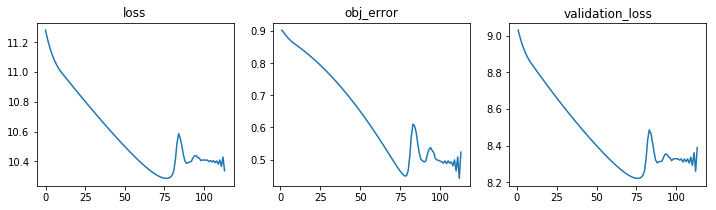

In [37]:
pr_adam.genPlotsRecons()
pr_adam.genPlotMetrics()

In [38]:
with pr_adam.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_adam = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_adam = flops_adam.total_float_ops
    print(flops_adam)

graph_def = pr_adam.graph.as_graph_def()
# To calculate the flops required for one adam step,
# I am removing the nodes required for the validation step.
nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr_adam.graph, nodes_validation)
print(flops_validation)

total_flops = (flops_adam - flops_validation) * pr_adam.data.index[-1]
print(f'total flops {total_flops:4.3g}')

549048743
22777709
total flops 5.95e+10
